In [1]:
# !pip install efficientnet_pytorch

In [2]:
!pip install pytorch-ignite

In [104]:
import os
import shutil
import zipfile
from sklearn.model_selection import train_test_split
from torch.utils.data import Dataset, DataLoader, ConcatDataset
from PIL import Image
import numpy as np
import torch
from torchvision import transforms
from torchvision import models
import time
import tqdm
import os
import seaborn as sns
from sklearn.metrics import confusion_matrix, f1_score

from torchvision.models import mobilenet_v3_small, mobilenet_v3_large
from efficientnet_pytorch import EfficientNet
import timm  # PyTorch Image Models (timm) 라이브러리
from torch.optim.lr_scheduler import ReduceLROnPlateau

In [4]:
torch.cuda.empty_cache()

### 로컬환경에서 이미지 압축파일을 업로드 하기위한 코드

In [5]:
# from IPython.display import display
# from ipywidgets import FileUpload

# upload_widget = FileUpload()
# display(upload_widget)

# # 선택한 파일을 확인하려면 아래 코드를 실행하세요.
# # upload_widget.value는 딕셔너리 형태로 업로드된 파일을 반환합니다.
# for filename in upload_widget.value:
#     print(f"Uploaded file: {filename}")

# # zip 파일도 여기서 업로드할 수 있는지 확인하자

In [6]:
print(os.getcwd())

c:\Users\SBA\repository\yolo


#### 1. 이미 압축이 해제되어 있다면 압축풀기 하지않고 넘어감 
#### 2. 압축폴더안의 파일이 모두 있으면(손상되거나 분실된 것이 없다면) 넘어감
#### 3. 만약 하나라도 손상된 파일이 있으면 모두 삭제하고 재 압축해제 
#### 4. zip파일의 디렉토리 구조를 무시하고 압축해제할 수 있는 코드 추가(하위폴더가 하나 더 생겨서 추가함)

In [7]:

# 데이터 경로 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리
data_dir = os.path.join(base_dir, 'data_intel')  # 'data' 폴더 생성
intel_zip = os.path.join(base_dir, 'intel-image-classification.zip')  # intel-image-classification.zip 파일 경로

# 압축 해제된 'train.zip'과 'test1.zip' 파일 경로 설정
train_data_zip = os.path.join(data_dir, 'seg_train.zip')
test_data_zip = os.path.join(data_dir, 'seg_test.zip')
valid_data_zip = os.path.join(data_dir,'seg_pred.zip')

# 압축 해제할 디렉토리 경로 설정
train_extract_path = os.path.join(data_dir, 'train')
test_extract_path = os.path.join(data_dir, 'test')
valid_extract_path = os.path.join(data_dir,'pred')

In [8]:
import os
import zipfile
import shutil

def count_files_in_dir(directory):
    """디렉토리 내의 파일 개수를 세는 함수"""
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def extract_zip_if_needed(zip_path, extract_path, expected_file_count):
    """압축 파일을 풀기 전에 파일 수를 확인하고, 파일이 부족하면 재압축 해제"""
    if os.path.exists(extract_path):
        current_file_count = count_files_in_dir(extract_path)
        if current_file_count == expected_file_count:
            print(f"{extract_path} already has {current_file_count} files. Skipping extraction.")
            return
        else:
            print(f"{extract_path} has {current_file_count} files, expected {expected_file_count}. Re-extracting.")
            shutil.rmtree(extract_path)  # 폴더 삭제
    else:
        print(f"{extract_path} does not exist. Extracting...")

    os.makedirs(extract_path, exist_ok=True)  # 압축 풀 디렉토리 생성

    # 압축 파일 내부의 디렉토리 구조를 무시하고 파일만 추출하는 방식으로 변경
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            filename = os.path.basename(member)  # 파일 이름만 추출
            if not filename:  # 폴더는 무시
                continue
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                target.write(source.read())
    print(f"Extracted {zip_path} to {extract_path}.")
    
    
def count_files_in_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 압축 파일 내 모든 항목(파일 및 디렉토리) 가져오기
        all_files = zip_ref.namelist()
        # 디렉토리가 아닌 실제 파일만 필터링
        actual_files = [f for f in all_files if not f.endswith('/')]
        return len(actual_files)




# 1. dogs-vs-cats.zip 파일 압축 풀기
if os.path.exists(intel_zip):
    print(f"Extracting {intel_zip}...")
    with zipfile.ZipFile(intel_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print(f"{intel_zip} extracted successfully!")
else:
    print(f"{intel_zip} not found.")

Extracting c:\Users\SBA\repository\yolo\intel-image-classification.zip...
c:\Users\SBA\repository\yolo\intel-image-classification.zip extracted successfully!


In [9]:
import os
import zipfile
import shutil

def count_files_in_dir(directory):
    """디렉토리 내의 파일 개수를 세는 함수"""
    total_files = 0
    for root, dirs, files in os.walk(directory):
        total_files += len(files)
    return total_files

def extract_zip_if_needed(zip_path, extract_path, expected_file_count):
    """압축 파일을 풀기 전에 파일 수를 확인하고, 파일이 부족하면 재압축 해제"""
    if os.path.exists(extract_path):
        current_file_count = count_files_in_dir(extract_path)
        if current_file_count == expected_file_count:
            print(f"{extract_path} already has {current_file_count} files. Skipping extraction.")
            return
        else:
            print(f"{extract_path} has {current_file_count} files, expected {expected_file_count}. Re-extracting.")
            shutil.rmtree(extract_path)  # 폴더 삭제
    else:
        print(f"{extract_path} does not exist. Extracting...")

    os.makedirs(extract_path, exist_ok=True)  # 압축 풀 디렉토리 생성

    # 압축 파일 내부의 디렉토리 구조를 무시하고 파일만 추출하는 방식으로 변경
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        for member in zip_ref.namelist():
            filename = os.path.basename(member)  # 파일 이름만 추출
            if not filename:  # 폴더는 무시
                continue
            source = zip_ref.open(member)
            target = open(os.path.join(extract_path, filename), "wb")
            with source, target:
                target.write(source.read())
    print(f"Extracted {zip_path} to {extract_path}.")
    
    
def count_files_in_zip(zip_path):
    with zipfile.ZipFile(zip_path, 'r') as zip_ref:
        # 압축 파일 내 모든 항목(파일 및 디렉토리) 가져오기
        all_files = zip_ref.namelist()
        # 디렉토리가 아닌 실제 파일만 필터링
        actual_files = [f for f in all_files if not f.endswith('/')]
        return len(actual_files)




# 1. dogs-vs-cats.zip 파일 압축 풀기
if os.path.exists(intel_zip):
    print(f"Extracting {intel_zip}...")
    with zipfile.ZipFile(intel_zip, 'r') as zip_ref:
        zip_ref.extractall(data_dir)
    print(f"{intel_zip} extracted successfully!")
else:
    print(f"{intel_zip} not found.")
    
# 압축 해제된 'train.zip'과 'test1.zip' 파일 경로 설정
train_data_zip = os.path.join(data_dir, 'seg_train.zip')
test_data_zip = os.path.join(data_dir, 'seg_test.zip')
valid_data_zip = os.path.join(data_dir,'seg_pred.zip')

# 압축 해제할 디렉토리 경로 설정
train_extract_path = os.path.join(data_dir, 'train')
test_extract_path = os.path.join(data_dir, 'test')
valid_extract_path = os.path.join(data_dir,'pred')


# 예상 파일 수 설정 (압축 파일 내부에 실제 파일 수에 맞게 설정)
#expected_train_files = 25000  # train.zip 내부의 이미지 파일 수
#expected_test_files = 12500  # test1.zip 내부의 이미지 파일 수

# train.zip 압축 풀기
if os.path.exists(train_data_zip):
    extract_zip_if_needed(train_data_zip, train_extract_path, expected_train_files)
else:
    print(f"{train_data_zip} not found.")

# test1.zip 압축 풀기
if os.path.exists(test_data_zip):
    extract_zip_if_needed(test_data_zip, test_extract_path, expected_test_files)
else:
    print(f"{test_data_zip} not found.")
    
# test1.zip 압축 풀기
if os.path.exists(test_data_zip):
    extract_zip_if_needed(test_data_zip, test_extract_path, expected_test_files)
else:
    print(f"{test_data_zip} not found.")


Extracting c:\Users\SBA\repository\yolo\intel-image-classification.zip...
c:\Users\SBA\repository\yolo\intel-image-classification.zip extracted successfully!
c:\Users\SBA\repository\yolo\data_intel\seg_train.zip not found.
c:\Users\SBA\repository\yolo\data_intel\seg_test.zip not found.
c:\Users\SBA\repository\yolo\data_intel\seg_test.zip not found.


In [10]:
directory = 'data_intel\seg_pred\seg_pred'
file_count = len(os.listdir(directory))
print(f"'{directory}' 이하의 모든 폴더의 파일 개수: {file_count}")

'data_intel\seg_pred\seg_pred' 이하의 모든 폴더의 파일 개수: 7301


In [11]:
def count_all_files_in_directory(directory):
    total_files = 0
    # os.walk를 사용해 하위 디렉토리까지 모두 탐색
    for root, dirs, files in os.walk(directory):
        total_files += len(files)  # 현재 디렉토리의 파일 개수를 더함
    return total_files

# 디렉토리 경로 설정
directory = 'data_intel/seg_train/seg_train'

# 파일 개수 출력
file_count = count_all_files_in_directory(directory)
print(f"'{directory}' 이하의 모든 폴더의 파일 개수: {file_count}")

'data_intel/seg_train/seg_train' 이하의 모든 폴더의 파일 개수: 14034


In [12]:
def count_all_files_in_directory(directory):
    total_files = 0
    # os.walk를 사용해 하위 디렉토리까지 모두 탐색
    for root, dirs, files in os.walk(directory):
        total_files += len(files)  # 현재 디렉토리의 파일 개수를 더함
    return total_files

# 디렉토리 경로 설정
directory = 'data_intel/seg_test/seg_test'

# 파일 개수 출력
file_count = count_all_files_in_directory(directory)
print(f"'{directory}' 이하의 모든 폴더의 파일 개수: {file_count}")

'data_intel/seg_test/seg_test' 이하의 모든 폴더의 파일 개수: 3000


In [13]:
def collect_all_file_paths(directory):
    file_paths = []
    # os.walk를 사용해 모든 하위 폴더를 재귀적으로 탐색
    for root, dirs, files in os.walk(directory):
        for file in files:
            # 파일의 전체 경로를 생성하여 리스트에 추가
            file_paths.append(os.path.join(root, file))
    return file_paths

# 디렉토리 경로 설정
train_dir = 'data_intel/seg_train/seg_train'

# 모든 하위 폴더의 파일 경로 수집
all_train_paths = collect_all_file_paths(train_dir)

# 파일 경로 리스트 출력 (원한다면)
for path in all_train_paths:
    print(path)

data_intel/seg_train/seg_train\buildings\0.jpg
data_intel/seg_train/seg_train\buildings\10006.jpg
data_intel/seg_train/seg_train\buildings\1001.jpg
data_intel/seg_train/seg_train\buildings\10014.jpg
data_intel/seg_train/seg_train\buildings\10018.jpg
data_intel/seg_train/seg_train\buildings\10029.jpg
data_intel/seg_train/seg_train\buildings\10032.jpg
data_intel/seg_train/seg_train\buildings\10056.jpg
data_intel/seg_train/seg_train\buildings\1009.jpg
data_intel/seg_train/seg_train\buildings\10113.jpg
data_intel/seg_train/seg_train\buildings\1012.jpg
data_intel/seg_train/seg_train\buildings\10126.jpg
data_intel/seg_train/seg_train\buildings\10144.jpg
data_intel/seg_train/seg_train\buildings\10151.jpg
data_intel/seg_train/seg_train\buildings\10161.jpg
data_intel/seg_train/seg_train\buildings\10165.jpg
data_intel/seg_train/seg_train\buildings\10176.jpg
data_intel/seg_train/seg_train\buildings\10184.jpg
data_intel/seg_train/seg_train\buildings\10185.jpg
data_intel/seg_train/seg_train\buildin

In [14]:
import os

# 현재 작업 디렉토리 확인
print("현재 작업 디렉토리:", os.getcwd())

현재 작업 디렉토리: c:\Users\SBA\repository\yolo


#### 분리된 데이터를 담아둘 폴더 경로설정 및 생성

#### 시드함수추가

In [15]:
import random
import numpy as np

# 시드 설정 함수 정의
def set_seed(seed):
    random.seed(seed)
    np.random.seed(seed)
    torch.manual_seed(seed)
    if torch.cuda.is_available():
        torch.cuda.manual_seed(seed)
        torch.cuda.manual_seed_all(seed)  # 여러 GPU 사용 시
    torch.backends.cudnn.deterministic = True
    torch.backends.cudnn.benchmark = False

# 시드 설정
set_seed(42)

In [16]:
import os
import random
import shutil

def collect_and_shuffle_files(data_dir):
    """
    주어진 디렉토리 내의 모든 파일을 수집하여 랜덤하게 섞어 반환.
    하위 폴더에 있는 파일도 모두 포함.
    """
    all_files = []
    
    # os.walk를 사용해 하위 폴더 내의 모든 파일을 수집
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            all_files.append(os.path.join(root, file))
    
    # 파일 리스트를 랜덤하게 섞음
    random.shuffle(all_files)
    
    return all_files

def split_data_files(data_dir, output_dir, train_ratio=0.8, seed=42):
    """
    데이터를 학습(train)과 검증(valid)으로 분할하고, 데이터를 새 폴더에 저장합니다.
    data_dir: 원본 데이터가 있는 폴더 경로
    output_dir: 분할된 데이터를 저장할 폴더 경로
    train_ratio: 학습 데이터 비율 (기본값: 0.8)
    seed: 랜덤 시드 값
    """
    # 랜덤 시드 고정
    random.seed(seed)

    # 학습 및 검증 폴더 생성
    train_output_dir = os.path.join(output_dir, 'train')
    valid_output_dir = os.path.join(output_dir, 'valid')

    os.makedirs(train_output_dir, exist_ok=True)
    os.makedirs(valid_output_dir, exist_ok=True)

    # 모든 파일을 수집하고 섞음
    all_files = collect_and_shuffle_files(data_dir)
    total_num = len(all_files)

    # 학습 데이터와 검증 데이터로 분할
    train_num = int(total_num * train_ratio)
    train_files = all_files[:train_num]
    valid_files = all_files[train_num:]

    # 파일을 새로운 폴더로 복사
    for file in train_files:
        # 하위 폴더 구조를 유지하면서 복사
        relative_path = os.path.relpath(file, data_dir)
        train_dest_path = os.path.join(train_output_dir, relative_path)
        os.makedirs(os.path.dirname(train_dest_path), exist_ok=True)
        shutil.copy(file, train_dest_path)

    for file in valid_files:
        # 하위 폴더 구조를 유지하면서 복사
        relative_path = os.path.relpath(file, data_dir)
        valid_dest_path = os.path.join(valid_output_dir, relative_path)
        os.makedirs(os.path.dirname(valid_dest_path), exist_ok=True)
        shutil.copy(file, valid_dest_path)

    print(f"Train files: {len(train_files)}개")
    print(f"Valid files: {len(valid_files)}개")

# 경로 설정
train_data_dir = 'data_intel/seg_train/seg_train'
output_dir = 'data_intel/split_data'

# 데이터 분할 및 저장
split_data_files(train_data_dir, output_dir, train_ratio=0.8)

Train files: 11227개
Valid files: 2807개


In [17]:
import os
import random
import shutil

def collect_and_shuffle_files(data_dir):
    """
    주어진 디렉토리 내의 모든 파일을 수집하여 랜덤하게 섞어 반환.
    하위 폴더에 있는 파일도 모두 포함.
    """
    all_files = []
    
    # os.walk를 사용해 하위 폴더 내의 모든 파일을 수집
    for root, dirs, files in os.walk(data_dir):
        for file in files:
            all_files.append(os.path.join(root, file))
    
    # 파일 리스트를 랜덤하게 섞음
    random.shuffle(all_files)
    
    return all_files

def split_test_files(data_dir, num_samples, seed=42):
    """
    테스트 데이터를 랜덤하게 추출합니다.
    data_dir: 원본 테스트 데이터가 있는 폴더 경로
    num_samples: 랜덤하게 추출할 파일 개수
    seed: 랜덤 시드 값
    """
    # 랜덤 시드 고정
    random.seed(seed)

    # 모든 파일을 수집하고 섞음
    all_files = collect_and_shuffle_files(data_dir)

    # 요청된 개수만큼 파일을 랜덤하게 추출
    if num_samples > len(all_files):
        print(f"Warning: 요청된 파일 개수({num_samples})가 실제 파일 수({len(all_files)})보다 큽니다.")
        num_samples = len(all_files)

    selected_files = all_files[:num_samples]

    return selected_files

def copy_files_to_test_dir(selected_files, dest_dir, data_dir):
    """
    선택된 테스트 파일을 지정된 디렉토리로 복사
    selected_files: 선택된 파일 경로 리스트
    dest_dir: 복사할 목적 디렉토리
    data_dir: 원본 데이터 디렉토리 경로
    """
    # 목적 폴더가 없으면 생성
    if not os.path.exists(dest_dir):
        os.makedirs(dest_dir)

    for file in selected_files:
        # 원본 폴더 구조를 유지하면서 파일 복사
        relative_path = os.path.relpath(file, data_dir)
        destination = os.path.join(dest_dir, relative_path)
        
        # 하위 디렉토리 생성
        os.makedirs(os.path.dirname(destination), exist_ok=True)
        
        # 파일 복사
        shutil.copy(file, destination)

    print(f"{len(selected_files)}개의 파일이 '{dest_dir}'에 복사되었습니다.")

# 경로 설정
test_data_dir = 'data_intel/seg_test/seg_test'  # 원본 테스트 데이터 경로
split_data_test_dir = 'data_intel/split_data/test'  # 테스트 데이터를 복사할 경로

# 테스트 데이터에서 랜덤하게 추출할 파일 수 설정
num_samples = 1000  # 원하는 만큼 설정

# 테스트 데이터에서 랜덤 파일 추출
random_test_files = split_test_files(test_data_dir, num_samples)
print(f"Test files: {len(random_test_files)}개")

# 추출된 파일을 split_data/test 폴더로 복사
copy_files_to_test_dir(random_test_files, split_data_test_dir, test_data_dir)

Test files: 1000개
1000개의 파일이 'data_intel/split_data/test'에 복사되었습니다.


In [18]:
test_data_dir

'data_intel/seg_test/seg_test'

In [19]:
def count_files_in_subfolders(directory):
    """
    주어진 디렉토리의 하위 폴더 내의 파일 개수를 반환하는 함수.
    하위 폴더 이름과 그 폴더 내 파일 개수를 딕셔너리로 반환.
    """
    folder_file_counts = {}

    # 주어진 디렉토리의 하위 폴더들 탐색
    for root, dirs, files in os.walk(directory):
        # 최상위 경로를 제외한 하위 폴더에 있는 파일만 계산
        if root != directory:
            folder_name = os.path.basename(root)  # 현재 폴더 이름
            folder_file_counts[folder_name] = len(files)  # 현재 폴더 내 파일 개수

    return folder_file_counts
# 경로 설정
train_dir = 'data_intel/split_data/train'
valid_dir = 'data_intel/split_data/valid'
test_dir = 'data_intel/split_data/test'

# 하위 폴더별 파일 개수 확인
train_file_counts = count_files_in_subfolders(train_dir)
valid_file_counts = count_files_in_subfolders(valid_dir)
test_file_counts = count_files_in_subfolders(test_dir)

# 출력
print("Train 데이터 하위 폴더별 파일 개수:")
for folder, count in train_file_counts.items():
    print(f"{folder}: {count}개")

print("\nValid 데이터 하위 폴더별 파일 개수:")
for folder, count in valid_file_counts.items():
    print(f"{folder}: {count}개")

print("\nTest 데이터 하위 폴더별 파일 개수:")
for folder, count in test_file_counts.items():
    print(f"{folder}: {count}개")

Train 데이터 하위 폴더별 파일 개수:
buildings: 1763개
forest: 1842개
glacier: 1914개
mountain: 1986개
sea: 1789개
street: 1933개

Valid 데이터 하위 폴더별 파일 개수:
buildings: 428개
forest: 429개
glacier: 490개
mountain: 526개
sea: 485개
street: 449개

Test 데이터 하위 폴더별 파일 개수:
buildings: 137개
forest: 158개
glacier: 174개
mountain: 172개
sea: 179개
street: 180개


### 테스트 데이터에 따른 2가지 커스텀 데이터셋 정의

In [20]:
import os
from PIL import Image
from torch.utils.data import Dataset
import numpy as np

class customDataset(Dataset):
    def __init__(self, files, root_dir, mode, transform=None, class_to_idx=None):
        """
        files: 파일 리스트
        root_dir: 파일들이 있는 폴더 경로
        mode: 'train' 또는 'test' 모드
        transform: 이미지 변환 파이프라인
        class_to_idx: 클래스 이름을 레이블로 변환하는 딕셔너리 (예: {'buildings': 0, 'forest': 1, ...})
        """
        self.files = files
        self.root_dir = root_dir
        self.mode = mode
        self.transform = transform
        self.class_to_idx = class_to_idx

    def __len__(self):
        return len(self.files)

    def __getitem__(self, idx):
        img_path = os.path.join(self.root_dir, self.files[idx])
        img = Image.open(img_path).convert('RGB')  # RGB로 변환하여 이미지를 읽음

        # 폴더 이름(클래스 이름)을 추출하여 레이블 설정
        folder_name = os.path.basename(os.path.dirname(img_path))
        label = self.class_to_idx[folder_name]

        if self.transform:
            img = self.transform(img)

        # 'train' 모드일 때는 이미지와 레이블 반환
        if self.mode == 'train':
            return img, np.array(label)

        # 'test' 모드일 때는 이미지와 파일 이름 반환 (레이블 없음)
        else:
            return img, self.files[idx]

In [68]:
class CustomTestDataset(Dataset):
    def __init__(self, root_dir, transform=None):
        """
        root_dir: 이미지 파일이 포함된 상위 디렉토리
        transform: 이미지 전처리 및 변환을 위한 torchvision.transforms 객체
        """
        self.root_dir = root_dir
        self.transform = transform

        # 모든 이미지 파일 경로를 저장
        self.image_paths = []
        self.labels = []

        # 클래스 이름을 인덱스로 변환하는 매핑 딕셔너리
        self.class_to_idx = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

        # 디렉토리 내의 각 이미지 파일 경로와 해당 클래스 레이블을 저장
        for class_name in os.listdir(root_dir):
            class_dir = os.path.join(root_dir, class_name)
            if os.path.isdir(class_dir):
                for img_file in os.listdir(class_dir):
                    if img_file.endswith(('.png', '.jpg', '.jpeg')):
                        self.image_paths.append(os.path.join(class_dir, img_file))
                        self.labels.append(self.class_to_idx[class_name])

    def __len__(self):
        return len(self.image_paths)

    def __getitem__(self, idx):
        img_path = self.image_paths[idx]
        label = self.labels[idx]
        image = Image.open(img_path).convert('RGB')

        if self.transform:
            image = self.transform(image)

        # 파일 이름 추출
        # filename = os.path.basename(img_path)
        filename = img_path
        
        return image, label,filename  # 이미지와 해당 레이블 반환

레이블이 없는 테스트 데이터 가져올때

#### 이미지 전처리

In [69]:
# 5. 이미지 전처리 설정
org_size = (256, 256)
img_size = 224
visual_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    # 평균이 0.5 표준편차 0.5 (0~1사이의 실수)
    transforms.ToTensor(),
    ])
train_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.RandomHorizontalFlip(),
    transforms.RandomCrop(img_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

test_transform = transforms.Compose([
    transforms.Resize(org_size),
    transforms.ToTensor(),
    transforms.Normalize((0.5, 0.5, 0.5), (0.5, 0.5, 0.5)),
])

#### 데이터셋 인스턴스화

In [70]:
# 데이터셋 인스턴스화

# Intel 데이터셋 경로 설정
train_dir = 'data_intel/split_data/train'
valid_dir = 'data_intel/split_data/valid'
test_dir = 'data_intel/split_data/test'

# 클래스별로 디렉토리가 나뉘어 있기 때문에 각 클래스 디렉토리에서 파일을 읽어와야 함
class_to_idx = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}

# 각 클래스별 파일 목록 수집
train_files = {cls: os.listdir(os.path.join(train_dir, cls)) for cls in class_to_idx}
valid_files = {cls: os.listdir(os.path.join(valid_dir, cls)) for cls in class_to_idx}


# 데이터셋 생성 (클래스별로)
visual_datasets = []
train_datasets = []
valid_datasets = []
test_datasets = []

for cls in class_to_idx:
    visual_datasets.append(customDataset(train_files[cls], os.path.join(train_dir, cls), 'train', transform=visual_transform,class_to_idx=class_to_idx))
    train_datasets.append(customDataset(train_files[cls], os.path.join(train_dir, cls), 'train', transform=train_transform,class_to_idx=class_to_idx))
    valid_datasets.append(customDataset(valid_files[cls], os.path.join(valid_dir, cls), 'train', transform=train_transform,class_to_idx=class_to_idx))
    # 테스트 데이터셋 생성
test_dataset = CustomTestDataset(root_dir=test_dir, transform=test_transform)

# 데이터셋 결합 (모든 클래스 통합)
visual_dataset = ConcatDataset(visual_datasets)
train_dataset = ConcatDataset(train_datasets)
valid_dataset = ConcatDataset(valid_datasets)
#test_dataset = ConcatDataset(test_datasets)

# 학습용 시각화 데이터셋 (원하는 경우 추가)
# visual_dataset = ConcatDataset([...])

# 데이터셋 크기 출력
print(f"visual dataset size: {len(visual_dataset)}")
print(f"Train dataset size: {len(train_dataset)}")
print(f"Valid dataset size: {len(valid_dataset)}")
print(f"Test dataset size: {len(test_dataset)}")

print(class_to_idx)


visual dataset size: 11227
Train dataset size: 11227
Valid dataset size: 2807
Test dataset size: 1000
{'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}


#### 데이터로더 인스턴스화

In [71]:
# 데이터로더 객체생성

from torch.utils.data import DataLoader

batch_size = 32
visual_loader = DataLoader(visual_dataset, batch_size=batch_size, shuffle=True)
train_loader = DataLoader(train_dataset, batch_size = batch_size, shuffle = True)
valid_loader = DataLoader(valid_dataset, batch_size = batch_size, shuffle = False)
test_loader = DataLoader(test_dataset, batch_size = batch_size, shuffle = False)

In [72]:
import matplotlib.pyplot as plt

# 배치사이즈만큼의 이미지를 시각화함함
images, labels = next(iter(visual_loader))
classes ={0:'buildings',1:'forest', 2: 'glacier', 3:'mountain', 4: 'sea', 5: 'street' }


# labels의 타입이 정수형인지 확인
print("라벨의 고유 값:", labels.unique())

라벨의 고유 값: tensor([0, 1, 2, 3, 4, 5], dtype=torch.int32)


#### 가져올 데이터 시각화

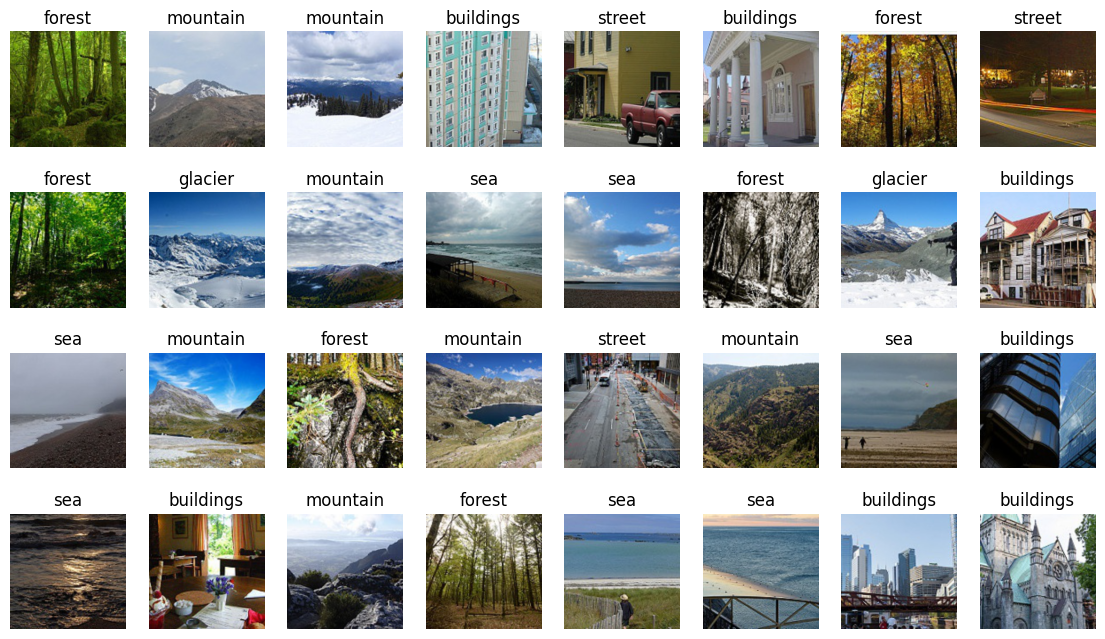

In [73]:
import matplotlib.pyplot as plt

# 배치사이즈만큼의 이미지를 시각화함함
images, labels = next(iter(visual_loader))
classes ={0:'buildings',1:'forest', 2: 'glacier', 3:'mountain', 4: 'sea', 5: 'street' }

fig = plt.figure(figsize=(14, 8))
for i in range(batch_size):
    #4행 8열
    ax = fig.add_subplot(4, 8, i + 1)
    ax.set_title(classes[labels[i].item()])
    ax.axis('off')
    #컬러 채널 순서를 재정렬
    ax.imshow(images[i].permute(1, 2, 0))

plt.show()

#### 모델 정의 및 설정

In [115]:
import torch
import torch.nn as nn
import torchvision
from efficientnet_pytorch import EfficientNet

# device 설정
device = 'cuda' if torch.cuda.is_available() else 'cpu'

# He 초기화를 적용하는 함수 정의
def initialize_weights_he(module):
    if isinstance(module, nn.Linear) or isinstance(module, nn.Conv2d):
        torch.nn.init.kaiming_normal_(module.weight, nonlinearity='relu')
        if module.bias is not None:
            torch.nn.init.zeros_(module.bias)

# 분류기 레이어를 수정하는 함수 정의
def modify_classifier(model, num_features, num_classes, model_name):
    """모델의 분류기 레이어를 수정하고 He 초기화를 적용하는 함수"""
    classifier = nn.Sequential(
        nn.Linear(num_features, 512),
        nn.ReLU(),
        nn.Dropout(0.5),
        nn.Linear(512, num_classes),
    ).to(device)
    
    # He 초기화 적용
    classifier.apply(initialize_weights_he)
    
    # 분류기 레이어에 학습 가능하도록 requires_grad 설정
    for param in classifier.parameters():
        param.requires_grad = True

    # 모델의 분류기 부분을 교체
    if model_name in ['efficientNetB2', 'efficientNetB0']:
        model._fc = classifier
    elif model_name in ['MNV3_large', 'MNV3_small']:
        model.classifier = classifier
    elif model_name in ['RESNET50', 'RESNET18']:
        model.fc = classifier

    return model

# 모델 생성 및 수정 함수
def create_model(model_name, num_classes):
    """모델 생성 및 수정"""
    if model_name == 'efficientNetB2':
        model = EfficientNet.from_pretrained('efficientnet-b2')
        num_features = model._fc.in_features
    elif model_name == 'efficientNetB0':
        model = EfficientNet.from_pretrained('efficientnet-b0')
        num_features = model._fc.in_features
    elif model_name == 'MNV3_large':
        model = torchvision.models.mobilenet_v3_large(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'MNV3_small':
        model = torchvision.models.mobilenet_v3_small(pretrained=True)
        num_features = model.classifier[0].in_features
    elif model_name == 'RESNET50':
        model = torchvision.models.resnet50(pretrained=True)
        num_features = model.fc.in_features
    elif model_name == 'RESNET18':
        model = torchvision.models.resnet18(pretrained=True)
        num_features = model.fc.in_features
    else:
        raise ValueError(f"Model '{model_name}' not recognized.")
    
    # 모든 파라미터 고정
    for param in model.parameters():
        param.requires_grad = False

    # 분류기 레이어 수정 및 학습 가능하게 설정
    model = modify_classifier(model, num_features, num_classes, model_name).to(device)

    # 모델을 GPU로 이동
    model = model.to(device)

    return model

# 선택 가능한 모델 출력
models = ['efficientNetB2', 'efficientNetB0', 'MNV3_large', 'MNV3_small', 'RESNET50', 'RESNET18']
print("사용 가능한 모델:")
for model_name in models:
    print(f" - {model_name}")

# 다중 분류를 위한 클래스 수 설정
num_classes = 6  # 예시: 6개의 클래스를 분류한다고 가정

# 모델 선택
selected_model_name = "RESNET50"  # 선택하려는 모델 이름

# 모델 생성
model = create_model(selected_model_name, num_classes)  # selected_model_name을 사용
print(f"선택된 모델: {selected_model_name}")


사용 가능한 모델:
 - efficientNetB2
 - efficientNetB0
 - MNV3_large
 - MNV3_small
 - RESNET50
 - RESNET18


c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:208: UserWarning: The parameter 'pretrained' is deprecated since 0.13 and may be removed in the future, please use 'weights' instead.
  warnings.warn(
c:\Users\SBA\anaconda3\envs\pytorch\lib\site-packages\torchvision\models\_utils.py:223: UserWarning: Arguments other than a weight enum or `None` for 'weights' are deprecated since 0.13 and may be removed in the future. The current behavior is equivalent to passing `weights=ResNet50_Weights.IMAGENET1K_V1`. You can also use `weights=ResNet50_Weights.DEFAULT` to get the most up-to-date weights.
  warnings.warn(msg)


선택된 모델: RESNET50


In [116]:
# EarlyStopping 클래스
class EarlyStopping:
    def __init__(self, patience=7, verbose=False, delta=0, path='checkpoint.pt'):
        """
        Args:
            patience (int): 성능 개선이 없을 때 몇 번의 에포크까지 기다릴지.
            verbose (bool): True일 경우 개선될 때마다 메시지 출력.
            delta (float): 성능 개선으로 간주될 최소 변화량.
        """
        self.patience = patience
        self.verbose = verbose
        self.counter = 0
        self.best_score = None
        self.early_stop = False
        self.val_loss_min = float('inf')
        self.delta = delta
        self.path = path

    def __call__(self, val_loss, model):
        score = -val_loss
        # 처음에 호출됐을때는 best_score가 None이라서 초기값을 설정
        if self.best_score is None:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
        # 지금까지의 best_scor
        elif score < self.best_score + self.delta:
            self.counter += 1
            if self.verbose:
                print(f'EarlyStopping counter: {self.counter} out of {self.patience}')
            if self.counter >= self.patience:
                self.early_stop = True
        else:
            self.best_score = score
            self.save_checkpoint(val_loss, model)
            self.counter = 0

    def save_checkpoint(self, val_loss, model):
        '''검증 손실이 감소하면 모델을 저장합니다.'''
        if self.verbose:
            print(f'Validation loss decreased ({self.val_loss_min:.6f} --> {val_loss:.6f}).  Saving model ...')
            torch.save(model.state_dict(), self.path)  # 모델 상태 저장
        self.val_loss_min = val_loss

In [29]:
from torchsummary import summary
summary(model, input_size = (3,256,256))

----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1         [-1, 64, 128, 128]           9,408
       BatchNorm2d-2         [-1, 64, 128, 128]             128
              ReLU-3         [-1, 64, 128, 128]               0
         MaxPool2d-4           [-1, 64, 64, 64]               0
            Conv2d-5           [-1, 64, 64, 64]          36,864
       BatchNorm2d-6           [-1, 64, 64, 64]             128
              ReLU-7           [-1, 64, 64, 64]               0
            Conv2d-8           [-1, 64, 64, 64]          36,864
       BatchNorm2d-9           [-1, 64, 64, 64]             128
             ReLU-10           [-1, 64, 64, 64]               0
       BasicBlock-11           [-1, 64, 64, 64]               0
           Conv2d-12           [-1, 64, 64, 64]          36,864
      BatchNorm2d-13           [-1, 64, 64, 64]             128
             ReLU-14           [-1, 64,

#### 손실함수 및 옵티마이저 정의(하이퍼파라미터 튜닝)

In [117]:
# 7. 손실함수 및 옵티마이저 정의
lr = 0.00001
epochs = 15
criterion = torch.nn.CrossEntropyLoss()
optimizer = torch.optim.Adam(model.parameters(), lr=lr)

# 학습률 조정(loss를 기준으로 한다면 mode가 min/ accuracy를 기준으로 한다면 max로 수정한다.)
scheduler = ReduceLROnPlateau(optimizer, mode='min', factor = 0.5, patience = 3)

# EarlyStopping 인스턴스 생성 (patience=10)
path = f"{selected_model_name}_best.pth"
early_stopping = EarlyStopping(patience=10, verbose=True, path=path)

#### fit 함수 정의

In [118]:
import time
import matplotlib.pyplot as plt
import numpy as np
from tqdm import tqdm

def imshow(img):
    # 이미지 정규화를 해제하기 위해 역변환
    img = img / 2 + 0.5  # (0.5, 0.5, 0.5)로 정규화된 이미지일 경우
    np_img = img.numpy()
    plt.imshow(np.transpose(np_img, (1, 2, 0)))
    plt.show()

def fit(model, criterion, optimizer, epochs, train_loader, valid_loader):
    # 훈련 시작시 초기 lr을 로딩
    pre_lr = optimizer.param_groups[0]['lr']
    model.train()

    train_loss = 0
    train_acc = 0
    train_correct = 0

    # 그래프를 출력하기 위해 리스트에 누적
    train_losses = []
    train_accuracies = []
    valid_losses = []
    valid_accuracies = []

    for epoch in range(epochs):
        start = time.time()

        # tqdm을 사용하여 각 에포크의 진행률 표시
        train_loader_tqdm = tqdm(train_loader, desc=f"Epoch {epoch+1}/{epochs} [Train]", leave=False)

        # 1 epoch 중에 train에 해당하는 for 문
        for train_x, train_y in train_loader_tqdm:
            model.train()
            train_x, train_y = train_x.to(device), train_y.to(device).long()
            
            # 레이블의 차원이 1D인지 확인 및 변환
            # if train_y.dim() > 1:
            #     train_y = train_y.squeeze()  # 레이블을 1D로 변환
            # 기울기 초기화
            optimizer.zero_grad()
            # 예측
            pred = model(train_x)
            # 손실계산
            loss = criterion(pred, train_y).squeeze()
            # 오차역전파
            loss.backward()
            # 진행
            optimizer.step()
            train_loss += loss.item()

            # 소프트맥스
            y_pred = pred.argmax(dim=1).cpu()
            # y_pred와 train_y값이 같으면 train_correct 추가
            train_correct += y_pred.eq(train_y.cpu()).int().sum()

        # validation data check
        valid_loss = 0
        valid_acc = 0
        valid_correct = 0

        # tqdm을 사용하여 각 에포크의 validation 진행률 표시
        valid_loader_tqdm = tqdm(valid_loader, desc=f"Epoch {epoch+1}/{epochs} [Validation]", leave=False)

        # 1 epoch 중에 validation에 해당하는 for 문
        for valid_x, valid_y in valid_loader_tqdm:
            with torch.no_grad():
                model.eval()
                valid_x, valid_y = valid_x.to(device), valid_y.to(device).long()
                # 레이블의 차원이 1D인지 확인 및 변환
                # if valid_y.dim() > 1:
                #     valid_y = valid_y.squeeze()  # 레이블을 1D로 변환
                pred = model(valid_x)
                loss = criterion(pred, valid_y).squeeze()
            valid_loss += loss.item()

            # 소프트맥스
            y_pred = pred.argmax(dim=1).cpu()
            valid_correct += y_pred.eq(valid_y.cpu()).int().sum()

        train_acc = train_correct / len(train_loader.dataset)
        valid_acc = valid_correct / len(valid_loader.dataset)

        print(f'{time.time() - start:.3f}sec : [Epoch {epoch+1}/{epochs}] -> train loss: {train_loss/len(train_loader):.4f}, train acc: {train_acc*100:.3f}% / valid loss: {valid_loss/len(valid_loader):.4f}, valid acc: {valid_acc*100:.3f}%')
        print('reserved:', round(torch.cuda.memory_reserved(0)/1024**2))
        train_losses.append(train_loss/len(train_loader))
        train_accuracies.append(train_acc)
        valid_losses.append(valid_loss/len(valid_loader))
        valid_accuracies.append(valid_acc)

        train_loss = 0
        train_acc = 0
        train_correct = 0
        
            # ReduceLROnPlateau 스케줄러를 사용하여 검증 손실에 따라 학습률을 조정
        scheduler.step(valid_loss)

        # 현재 학습률 출력
        now_lr = optimizer.param_groups[0]['lr']
        if now_lr != pre_lr:
            pre_lr = now_lr
            lr_str = ', LR changed!!'
        else:
            lr_str = ''

        print(f'learning_rate {epoch+1}: {now_lr:.8f}'+lr_str)

        # EarlyStopping을 호출하여 학습 중단 여부 확인
        early_stopping(valid_loss, model)

        # 학습 중단 조건을 충족하면 break
        if early_stopping.early_stop:
            print("Early stopping triggered.")
            break
        print('-' * 70)
        
    # 학습 및 검증 손실/정확도 시각화
    plt.plot(train_losses, label='Train Loss')
    plt.plot(valid_losses, label='Valid Loss')
    plt.legend()
    plt.title('Loss')
    plt.show()

    plt.plot(train_accuracies, label='Train Accuracy')
    plt.plot(valid_accuracies, label='Valid Accuracy')
    plt.legend()
    plt.title('Accuracy')
    plt.show()


In [119]:
from tqdm import tqdm

# 클래스 인덱스와 이름 매핑
class_to_idx = {'buildings': 0, 'forest': 1, 'glacier': 2, 'mountain': 3, 'sea': 4, 'street': 5}
idx_to_class = {v: k for k, v in class_to_idx.items()}

# 혼동 행렬(Confusion Matrix) 그리는 함수
def plot_confusion_matrix(labels, predictions, class_names):
    cm = confusion_matrix(labels, predictions)
    plt.figure(figsize=(10, 7))
    sns.heatmap(cm, annot=True, fmt='d', xticklabels=class_names, yticklabels=class_names)
    plt.xlabel('Predicted')
    plt.ylabel('True')
    plt.show()
    
# 테스트 데이터에서 성능을 평가하고, 예측이 잘못된 이미지를 시각화하는 함수
def evaluate_and_visualize(model, test_loader, criterion):
    test_loss = 0
    test_correct = 0
    test_total = 0
    incorrect_labels = []
    incorrect_preds = []
    incorrect_filenames = []
    all_labels = []  # 전체 실제 라벨 저장
    all_preds = []   # 전체 예측 라벨 저장
    
    model.eval()
    with torch.no_grad():
        for test_x, test_y, filenames in tqdm(test_loader):
            test_x, test_y = test_x.to(device), test_y.to(device).long()
            pred = model(test_x)
            loss = criterion(pred, test_y)
            test_loss += loss.item()

            # 예측 결과 처리
            y_pred = pred.argmax(dim=1).cpu()  # 다중 분류를 위한 argmax 사용

            # 정확도 계산
            test_correct += y_pred.eq(test_y.cpu()).int().sum().item()
            test_total += test_y.size(0)
            
            # 전체 라벨과 예측값 저장 (혼동 행렬을 위한 데이터)
            all_labels.extend(test_y.cpu().numpy())
            all_preds.extend(y_pred.cpu().numpy())

            
            # 잘못된 예측 저장 (각 요소별로 비교)
            for i in range(len(y_pred)):
                if y_pred[i] != test_y[i]:  # 예측과 실제가 다른 경우에만 저장
                    incorrect_labels.append(test_y.cpu()[i].item())
                    incorrect_preds.append(y_pred.cpu()[i].item())
                    incorrect_filenames.append(filenames[i])
                    

    test_accuracy = test_correct / test_total
    print(f"test_correct: {test_correct}, test_total: {test_total}")
    print(f'Test Loss: {test_loss / len(test_loader):.4f}, Test Accuracy: {test_accuracy * 100:.2f}%')
    
    # 혼동 행렬 시각화
    class_names = [idx_to_class[i] for i in range(len(class_to_idx))]
    plot_confusion_matrix(all_labels, all_preds, class_names)
    
    # 잘못 예측된 파일 이름만 추출
    just_filenames = [os.path.basename(path) for path in incorrect_filenames]

    # 예측이 잘못된 이미지 시각화
    fig = plt.figure(figsize=(12, 12))
    for i in range(min(16, len(incorrect_filenames))):
        ax = fig.add_subplot(4, 4, i + 1)
        # 잘못된 예측된 이미지 불러오기
        image = Image.open(incorrect_filenames[i])
        ax.imshow(image)

        # 실제 라벨과 예측 라벨 가져오기
        true_label = idx_to_class[incorrect_labels[i]]
        pred_label = idx_to_class[incorrect_preds[i]]
        ax.set_title(f'Pred: {pred_label}, Label: {true_label}, {just_filenames[i]}', fontsize=10)
        ax.axis('off')

    plt.tight_layout()
    plt.show()

#### 실제 테스트 데이터에 대한 결과 시각화하는 함수

In [52]:
#테스트 데이터를 어떻게 예측했는지 샘플 뽑아보기(일단 10개)

def visualize_predictions(model, test_loader, device, num_images=10):
    model.eval()  # 평가 모드로 전환
    count = 0  # 시각화한 이미지 개수를 세기 위한 변수
    with torch.no_grad():
        for test_x, filenames in test_loader:
            test_x = test_x.to(device)
            outputs = model(test_x)
            predictions = (outputs > 0.5).float()  # 시그모이드 출력으로 예측
            for i in range(test_x.size(0)):  # 배치 내 각 이미지에 대해
                if count >= num_images:  # 원하는 이미지 개수만 시각화
                    return
                img = test_x[i].cpu().permute(1, 2, 0).numpy()  # 이미지 형태 변환
                predicted_label = "Dog" if predictions[i].item() == 1 else "Cat"
                filename = filenames[i]

                # 이미지와 파일 이름, 예측 결과 시각화
                plt.imshow(img)
                plt.title(f"File: {filename}, Predicted: {predicted_label}")
                plt.axis('off')  # 축 제거
                plt.show()

                count += 1  # 시각화한 이미지 개수 증가


In [53]:
import torch
print(torch.__version__)

print(torch.version.cuda)

2.4.1
12.4


#### 학습

105.493sec : [Epoch 1/15] -> train loss: 1.3864, train acc: 46.700% / valid loss: 0.7834, valid acc: 78.910%
reserved: 958
learning_rate 1: 0.00001000
Validation loss decreased (inf --> 68.936103).  Saving model ...
----------------------------------------------------------------------


117.898sec : [Epoch 2/15] -> train loss: 0.7792, train acc: 72.522% / valid loss: 0.5267, valid acc: 85.536%
reserved: 958
learning_rate 2: 0.00001000
Validation loss decreased (68.936103 --> 46.346008).  Saving model ...
----------------------------------------------------------------------


122.629sec : [Epoch 3/15] -> train loss: 0.6030, train acc: 79.282% / valid loss: 0.4239, valid acc: 87.175%
reserved: 958
learning_rate 3: 0.00001000
Validation loss decreased (46.346008 --> 37.305517).  Saving model ...
----------------------------------------------------------------------


109.385sec : [Epoch 4/15] -> train loss: 0.5188, train acc: 81.642% / valid loss: 0.3797, valid acc: 87.638%
reserved: 958
learning_rate 4: 0.00001000
Validation loss decreased (37.305517 --> 33.412949).  Saving model ...
----------------------------------------------------------------------


123.319sec : [Epoch 5/15] -> train loss: 0.4581, train acc: 83.940% / valid loss: 0.3509, valid acc: 88.921%
reserved: 958
learning_rate 5: 0.00001000
Validation loss decreased (33.412949 --> 30.880999).  Saving model ...
----------------------------------------------------------------------


105.870sec : [Epoch 6/15] -> train loss: 0.4345, train acc: 84.332% / valid loss: 0.3286, valid acc: 88.742%
reserved: 958
learning_rate 6: 0.00001000
Validation loss decreased (30.880999 --> 28.917288).  Saving model ...
----------------------------------------------------------------------


109.160sec : [Epoch 7/15] -> train loss: 0.4067, train acc: 85.116% / valid loss: 0.3260, valid acc: 88.707%
reserved: 958
learning_rate 7: 0.00001000
Validation loss decreased (28.917288 --> 28.691637).  Saving model ...
----------------------------------------------------------------------


108.974sec : [Epoch 8/15] -> train loss: 0.3968, train acc: 85.873% / valid loss: 0.3127, valid acc: 89.312%
reserved: 958
learning_rate 8: 0.00001000
Validation loss decreased (28.691637 --> 27.517722).  Saving model ...
----------------------------------------------------------------------


104.837sec : [Epoch 9/15] -> train loss: 0.3788, train acc: 86.354% / valid loss: 0.3073, valid acc: 89.384%
reserved: 958
learning_rate 9: 0.00001000
Validation loss decreased (27.517722 --> 27.039174).  Saving model ...
----------------------------------------------------------------------


108.686sec : [Epoch 10/15] -> train loss: 0.3597, train acc: 87.076% / valid loss: 0.3019, valid acc: 89.704%
reserved: 958
learning_rate 10: 0.00001000
Validation loss decreased (27.039174 --> 26.567550).  Saving model ...
----------------------------------------------------------------------


106.384sec : [Epoch 11/15] -> train loss: 0.3581, train acc: 87.022% / valid loss: 0.2943, valid acc: 89.847%
reserved: 958
learning_rate 11: 0.00001000
Validation loss decreased (26.567550 --> 25.895257).  Saving model ...
----------------------------------------------------------------------


109.538sec : [Epoch 12/15] -> train loss: 0.3571, train acc: 87.468% / valid loss: 0.2887, valid acc: 89.954%
reserved: 958
learning_rate 12: 0.00001000
Validation loss decreased (25.895257 --> 25.408351).  Saving model ...
----------------------------------------------------------------------


108.614sec : [Epoch 13/15] -> train loss: 0.3418, train acc: 87.646% / valid loss: 0.2868, valid acc: 89.669%
reserved: 958
learning_rate 13: 0.00001000
Validation loss decreased (25.408351 --> 25.239230).  Saving model ...
----------------------------------------------------------------------


105.210sec : [Epoch 14/15] -> train loss: 0.3376, train acc: 87.779% / valid loss: 0.2840, valid acc: 89.989%
reserved: 958
learning_rate 14: 0.00001000
Validation loss decreased (25.239230 --> 24.993618).  Saving model ...
----------------------------------------------------------------------


108.788sec : [Epoch 15/15] -> train loss: 0.3270, train acc: 88.376% / valid loss: 0.2763, valid acc: 90.381%
reserved: 958
learning_rate 15: 0.00001000
Validation loss decreased (24.993618 --> 24.313802).  Saving model ...
----------------------------------------------------------------------


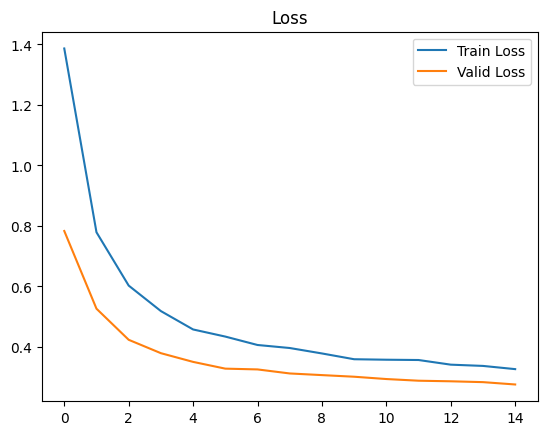

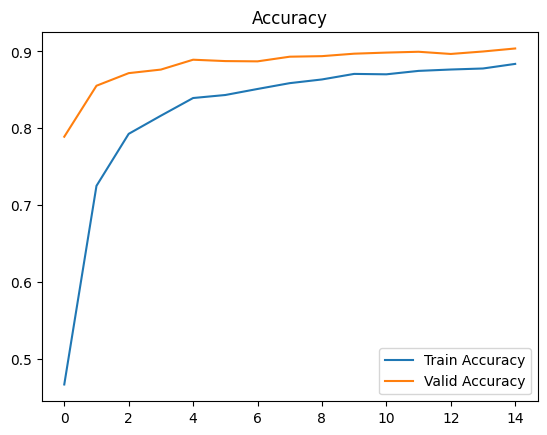

In [120]:
# 9. 모델 학습
fit(model, criterion, optimizer, epochs, train_loader, valid_loader)


In [58]:
import os
import torch
from datetime import datetime

# base 디렉토리 설정
base_dir = os.getcwd()  # 현재 작업 디렉토리

# base 디렉토리 아래에 'model' 폴더 경로 설정
modelPath = os.path.join(base_dir, 'model_intel')

# 폴더가 존재하지 않으면 생성
if not os.path.exists(modelPath):
    os.makedirs(modelPath)

# 모델 파일 이름 설정
# selected_model_name에 .pth 확장자를 추가
selected_model_name = f"{selected_model_name}.pth" if not selected_model_name.endswith(".pth") else selected_model_name

# 모델 저장
torch.save(model.state_dict(), os.path.join(modelPath, selected_model_name))

print(f"Model saved to {os.path.join(modelPath, selected_model_name)}")

Model saved to c:\Users\SBA\repository\yolo\model_intel\RESNET18.pth


100%|██████████| 32/32 [00:04<00:00,  7.79it/s]


test_correct: 219, test_total: 1000
Test Loss: 2.2495, Test Accuracy: 21.90%


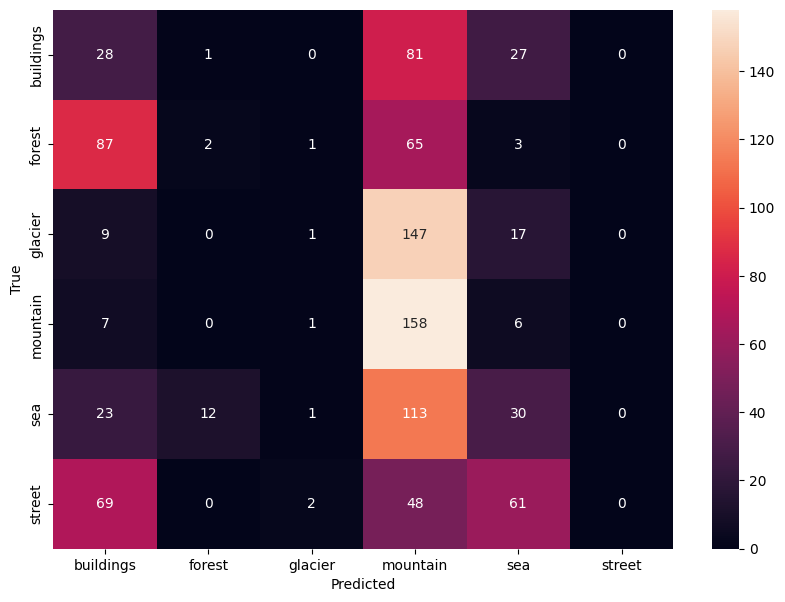

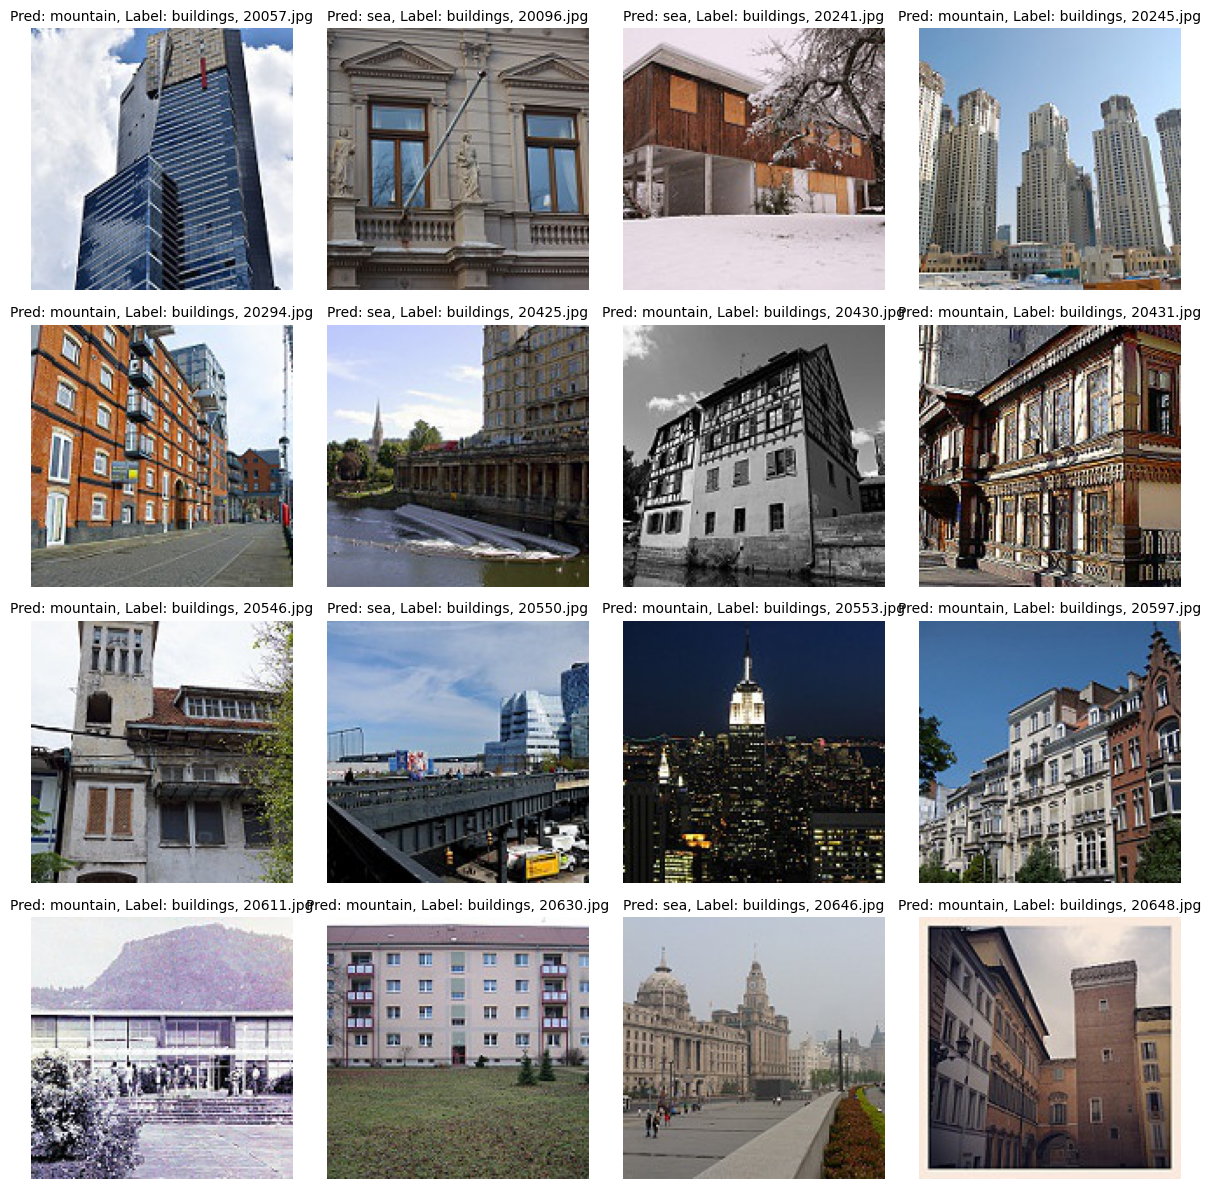

In [114]:
# 테스트 데이터를 통해 성능 평가 및 잘못된 예측 시각화
# 테스트 데이터에 레이블이 있는 경우
evaluate_and_visualize(model, test_loader, criterion)

In [ ]:
# 레이블 없는 테스트 데이터에 대한 시각화 실행
# visualize_predictions(model, test_loader, device)